In [1]:
import os
import pandas as pd
import numpy as np
import glob
import random

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%config InlineBackend.figure_formatrmat = 'retina'

In [4]:
avg_error_list = list()

In [2]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress
from stesml.model_tools import get_shuffle_results
from stesml.model_tools import get_T_from_h_results

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_progress_results

from stesml.postprocessing_tools import get_Cp
from stesml.postprocessing_tools import get_Ac
from stesml.postprocessing_tools import get_m
from stesml.postprocessing_tools import get_As
from stesml.postprocessing_tools import get_h
from stesml.postprocessing_tools import get_T

from stesml.data_tools import get_train_and_test_index_short
from stesml.data_tools import get_train_data_short

/Users/kmenear/Projects/envSulfurTES/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [115]:
model_type = "XGBoost"
is_recurrent = False
n_estimators = 300
target = 'h'
per_case = False
x = 0
t = 20

In [116]:
train_index, train_index_short, test_index = get_train_and_test_index_short(scenario_index, random_state=5)

In [117]:
X_train, y_train = get_train_data_short(scenario_index, train_index, train_index_short, target=target, t=t)
X_test, y_test = get_test_data(scenario_index, test_index, is_recurrent, target=target, x=x)

In [118]:
model = get_model(model_type, n_estimators)

In [119]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.75,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=6,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [120]:
y_hat = get_predictions(model, X_test, is_recurrent)

In [121]:
print(r2_score(y_test, y_hat))

0.9816832009100688


In [122]:
print(mean_squared_error(y_test, y_hat, squared=False))

7.984857418675098


In [123]:
test_df = load_data(scenario_index, test_index, x=x)

In [124]:
test_df[target+"_hat"] = y_hat

In [125]:
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent, target=target)

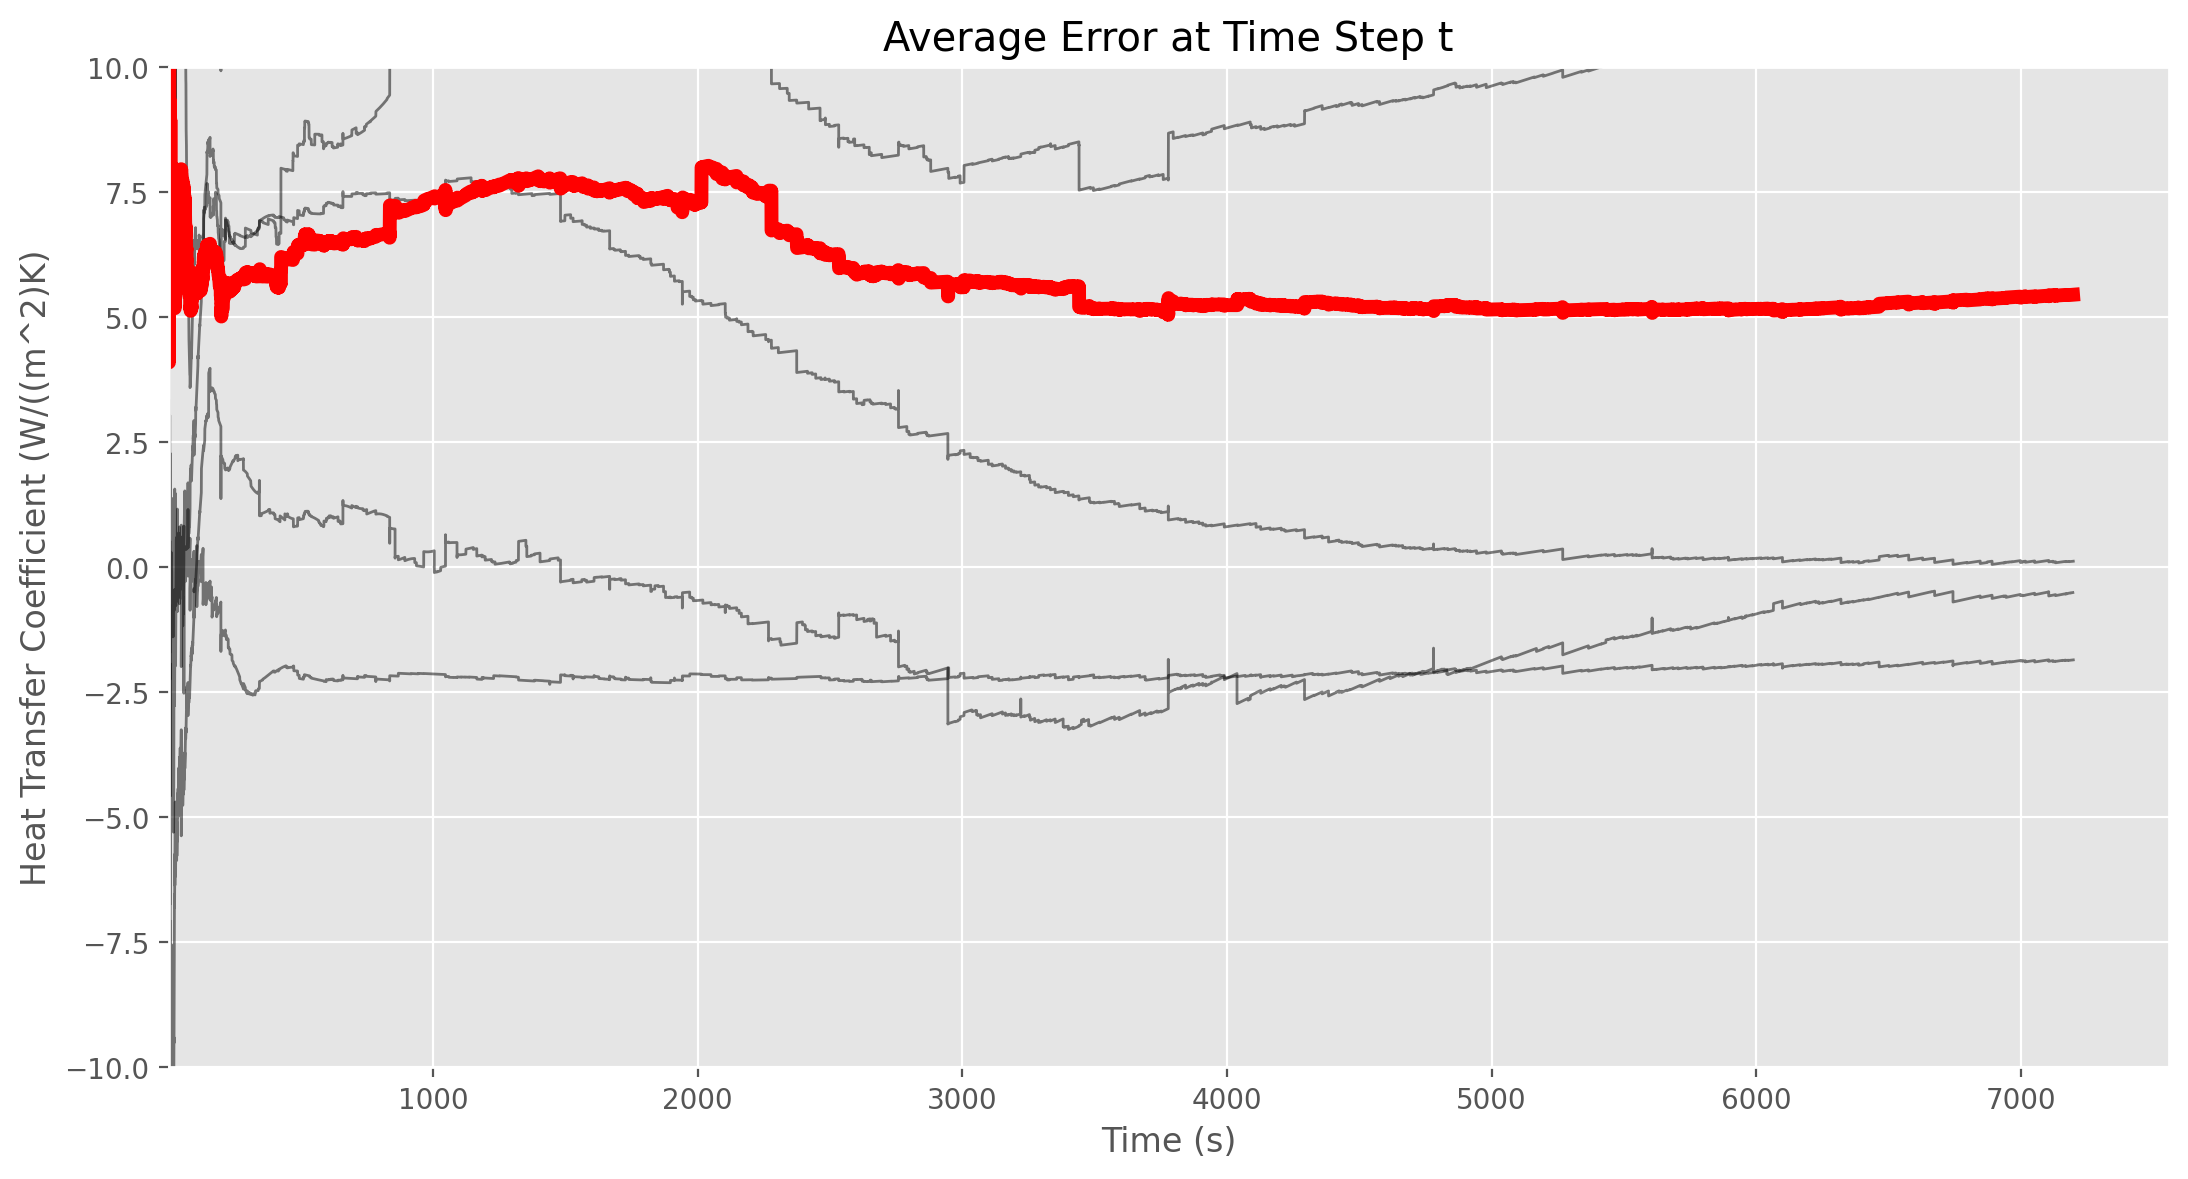

In [126]:
avg_err = plot_average_error(test_df_plot, target=target)

In [134]:
avg_error_list.insert(4,avg_err)

In [135]:
len(avg_error_list[5])

72000

In [136]:
avg_error_list

[0        37.593105
 1        37.593105
 2        37.683295
 3        35.884271
 4        36.243109
            ...    
 71995     2.519147
 71996     2.519074
 71997     2.519005
 71998     2.518933
 71999     2.518859
 Length: 72000, dtype: float64,
 0        73.872322
 1        73.872322
 2        71.456937
 3        68.975279
 4        69.564826
            ...    
 71995     2.011120
 71996     2.011078
 71997     2.011040
 71998     2.010998
 71999     2.010956
 Length: 72000, dtype: float64,
 0        43.700789
 1        43.700789
 2        42.178358
 3        40.218366
 4        43.559554
            ...    
 71995     2.849327
 71996     2.849254
 71997     2.849185
 71998     2.849113
 71999     2.849039
 Length: 72000, dtype: float64,
 0        45.446446
 1        45.446446
 2        47.345372
 3        44.238024
 4        44.159908
            ...    
 71995     1.761017
 71996     1.760944
 71997     1.760876
 71998     1.760803
 71999     1.760730
 Length: 72000, dtype: f

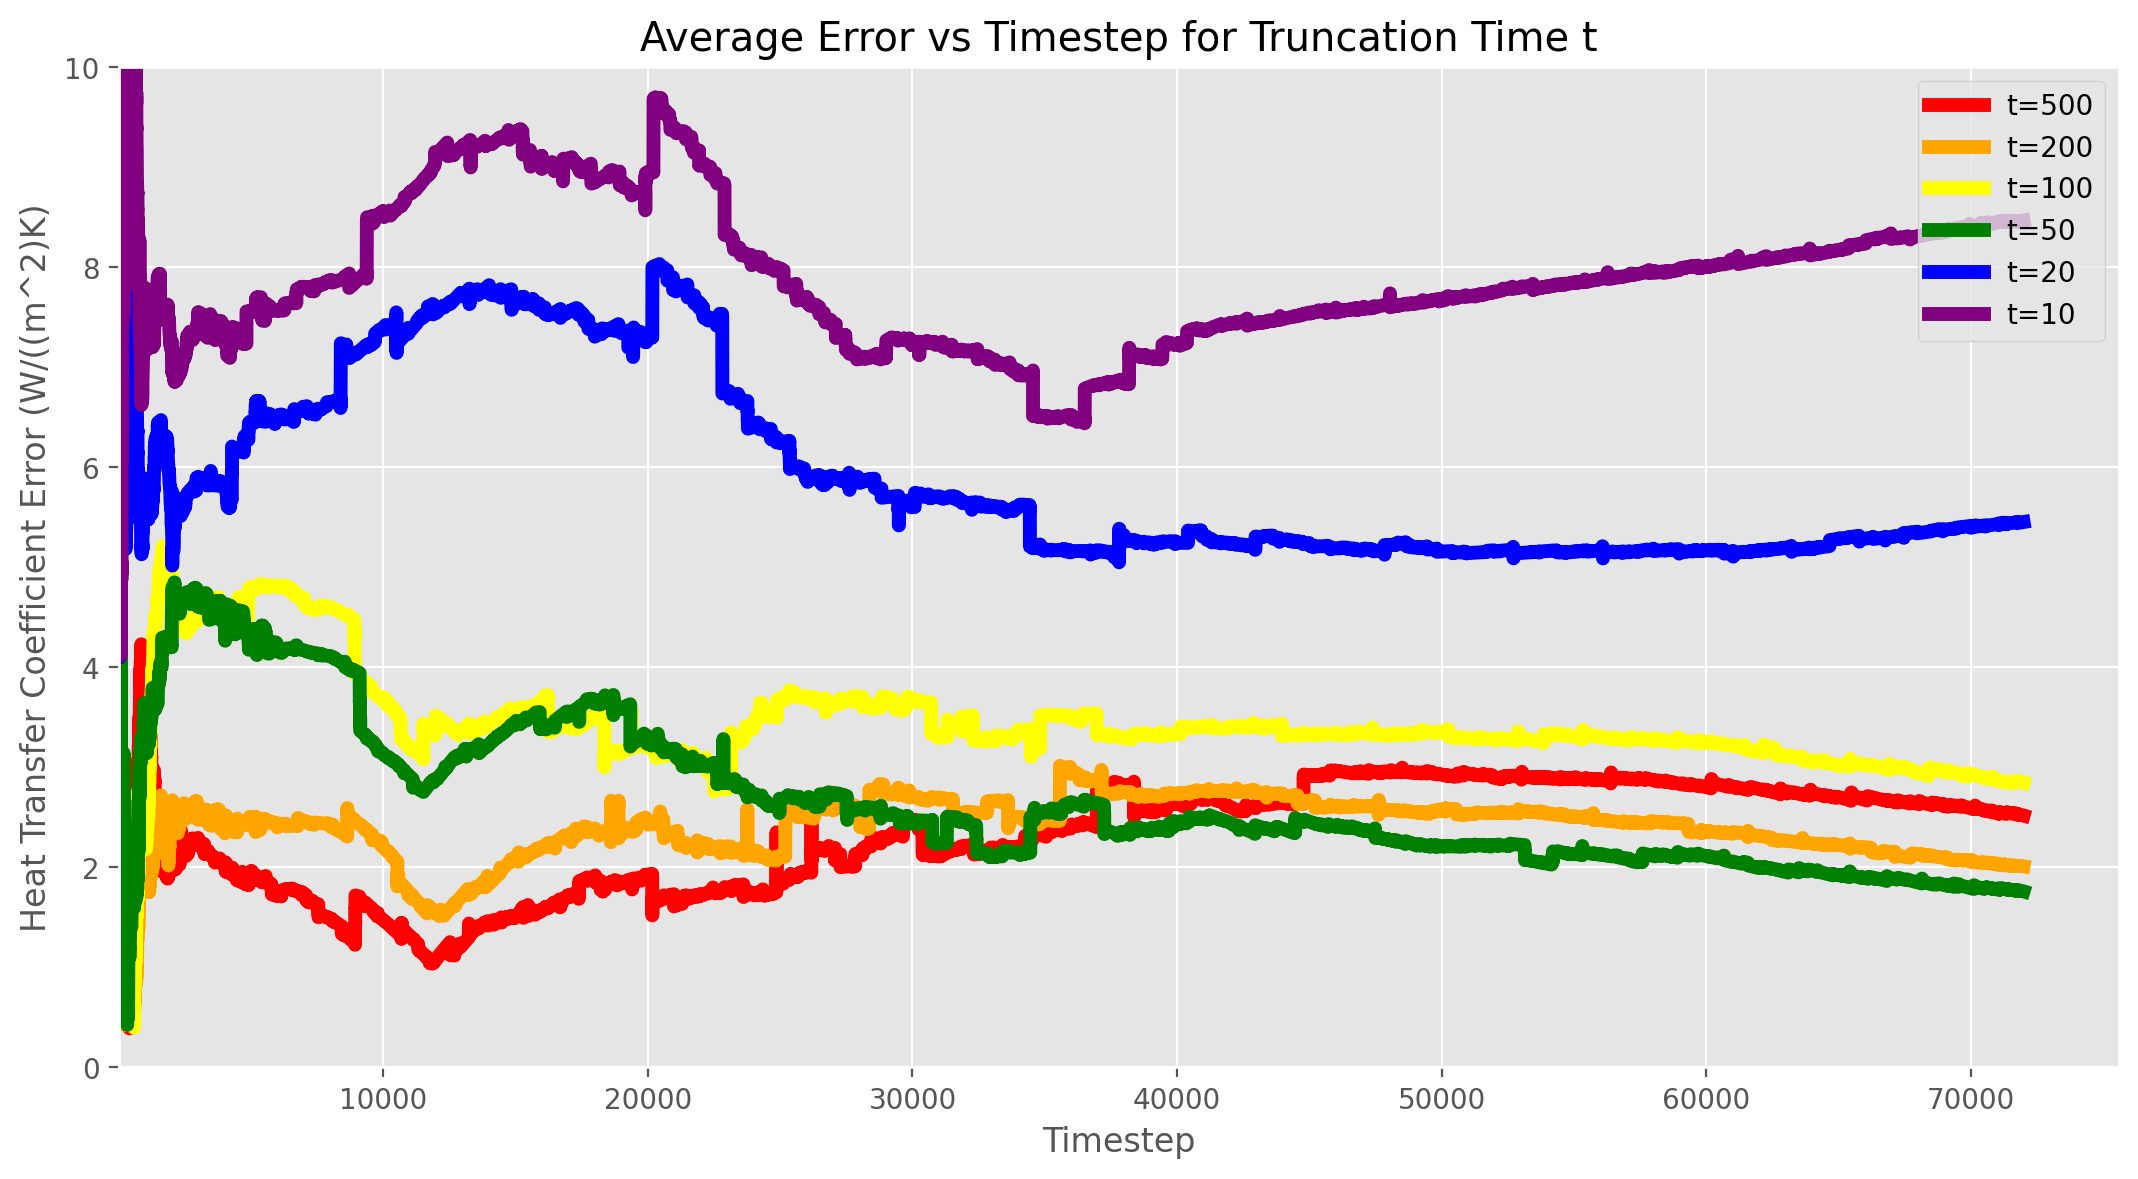

In [140]:
ax = plt.figure(figsize=(10,5), dpi = 200).add_axes([0,0,1,1])
colors = ['red','orange','yellow','green','blue','purple']
t_val = ['t=500','t=200','t=100','t=50','t=20','t=10']
for i, ae in enumerate(avg_error_list):
    ax.plot(ae, color=colors[i], linewidth=5, label=t_val[i])
ax.set_xlim(1)
ax.set_ylim(0,10)
plt.xlabel("Timestep")
plt.ylabel("Heat Transfer Coefficient Error (W/((m^2)K)")
plt.title('Average Error vs Timestep for Truncation Time t')
plt.legend(loc='upper right')
plt.show()

<AxesSubplot:>

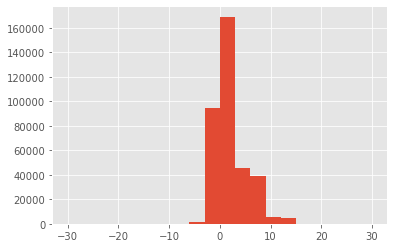

In [208]:
(test_df_plot[target] - test_df_plot[target+'_hat']).hist(bins=20, range=(-30, 30))

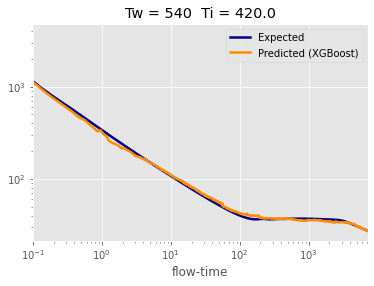

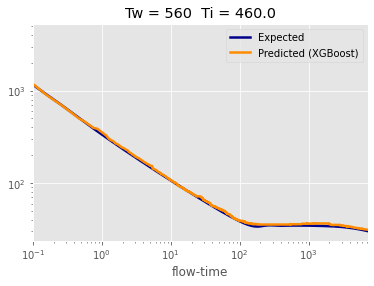

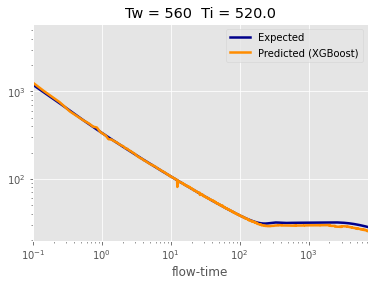

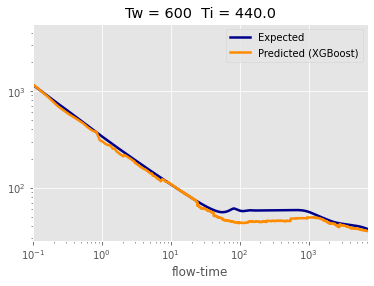

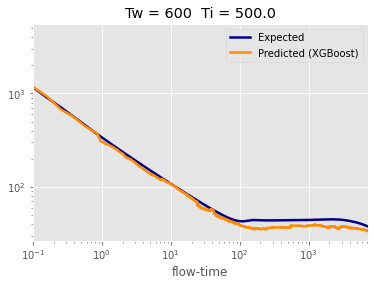

In [209]:
plot_test_results(test_df_plot, model_type, target=target)

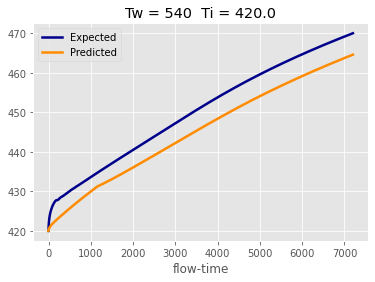

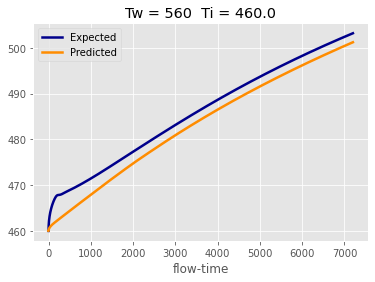

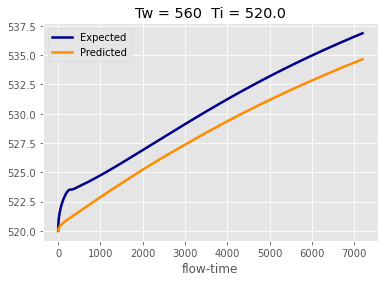

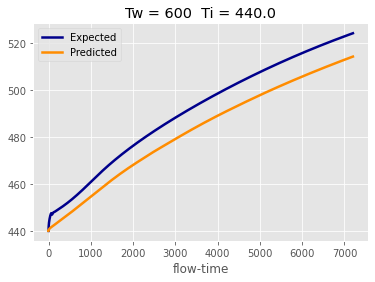

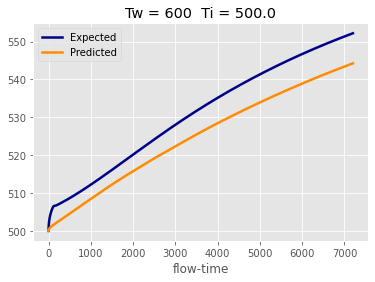

In [210]:
if target == 'h':
    rmse_T, r2_T = get_T_from_h_results(test_df, plot=True)

In [78]:
print(r2_T)

0.9831072503042857


In [79]:
print(rmse_T)

4.3576266543083575


In [5]:
model_type = "XGBoost"
is_recurrent = False
target = 'Tavg'
per_case = False
x = 0

min_estimators = 100
max_estimators = 1000
step_size = 100
n_shuffle_iterations = 20

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x)

Estimators: 100 Shuffle: 0 RMSE: 12.160723625929567 R2: 0.945041491463394
Estimators: 100 Shuffle: 1 RMSE: 10.737816079473408 R2: 0.9164462202071451
Estimators: 100 Shuffle: 2 RMSE: 10.18657588046308 R2: 0.926035848043426
Estimators: 100 Shuffle: 3 RMSE: 10.763187555791177 R2: 0.9008206508821999
Estimators: 100 Shuffle: 4 RMSE: 10.829881920718845 R2: 0.9022669006647751
Estimators: 100 Shuffle: 5 RMSE: 10.791686814743843 R2: 0.9096366294326431
Estimators: 100 Shuffle: 6 RMSE: 10.753734224036988 R2: 0.9145842150082016
Estimators: 100 Shuffle: 7 RMSE: 11.367316127426747 R2: 0.8915613947573552
Estimators: 100 Shuffle: 8 RMSE: 11.652609748436435 R2: 0.8908814747461018
Estimators: 100 Shuffle: 9 RMSE: 11.231159938503898 R2: 0.8950921441094613
Estimators: 100 Shuffle: 10 RMSE: 10.980706350446098 R2: 0.9021037158945304
Estimators: 100 Shuffle: 11 RMSE: 11.418684619705049 R2: 0.8979781740739682
Estimators: 100 Shuffle: 12 RMSE: 11.662522254878208 R2: 0.8802025742689422
Estimators: 100 Shuffle: 


KeyboardInterrupt



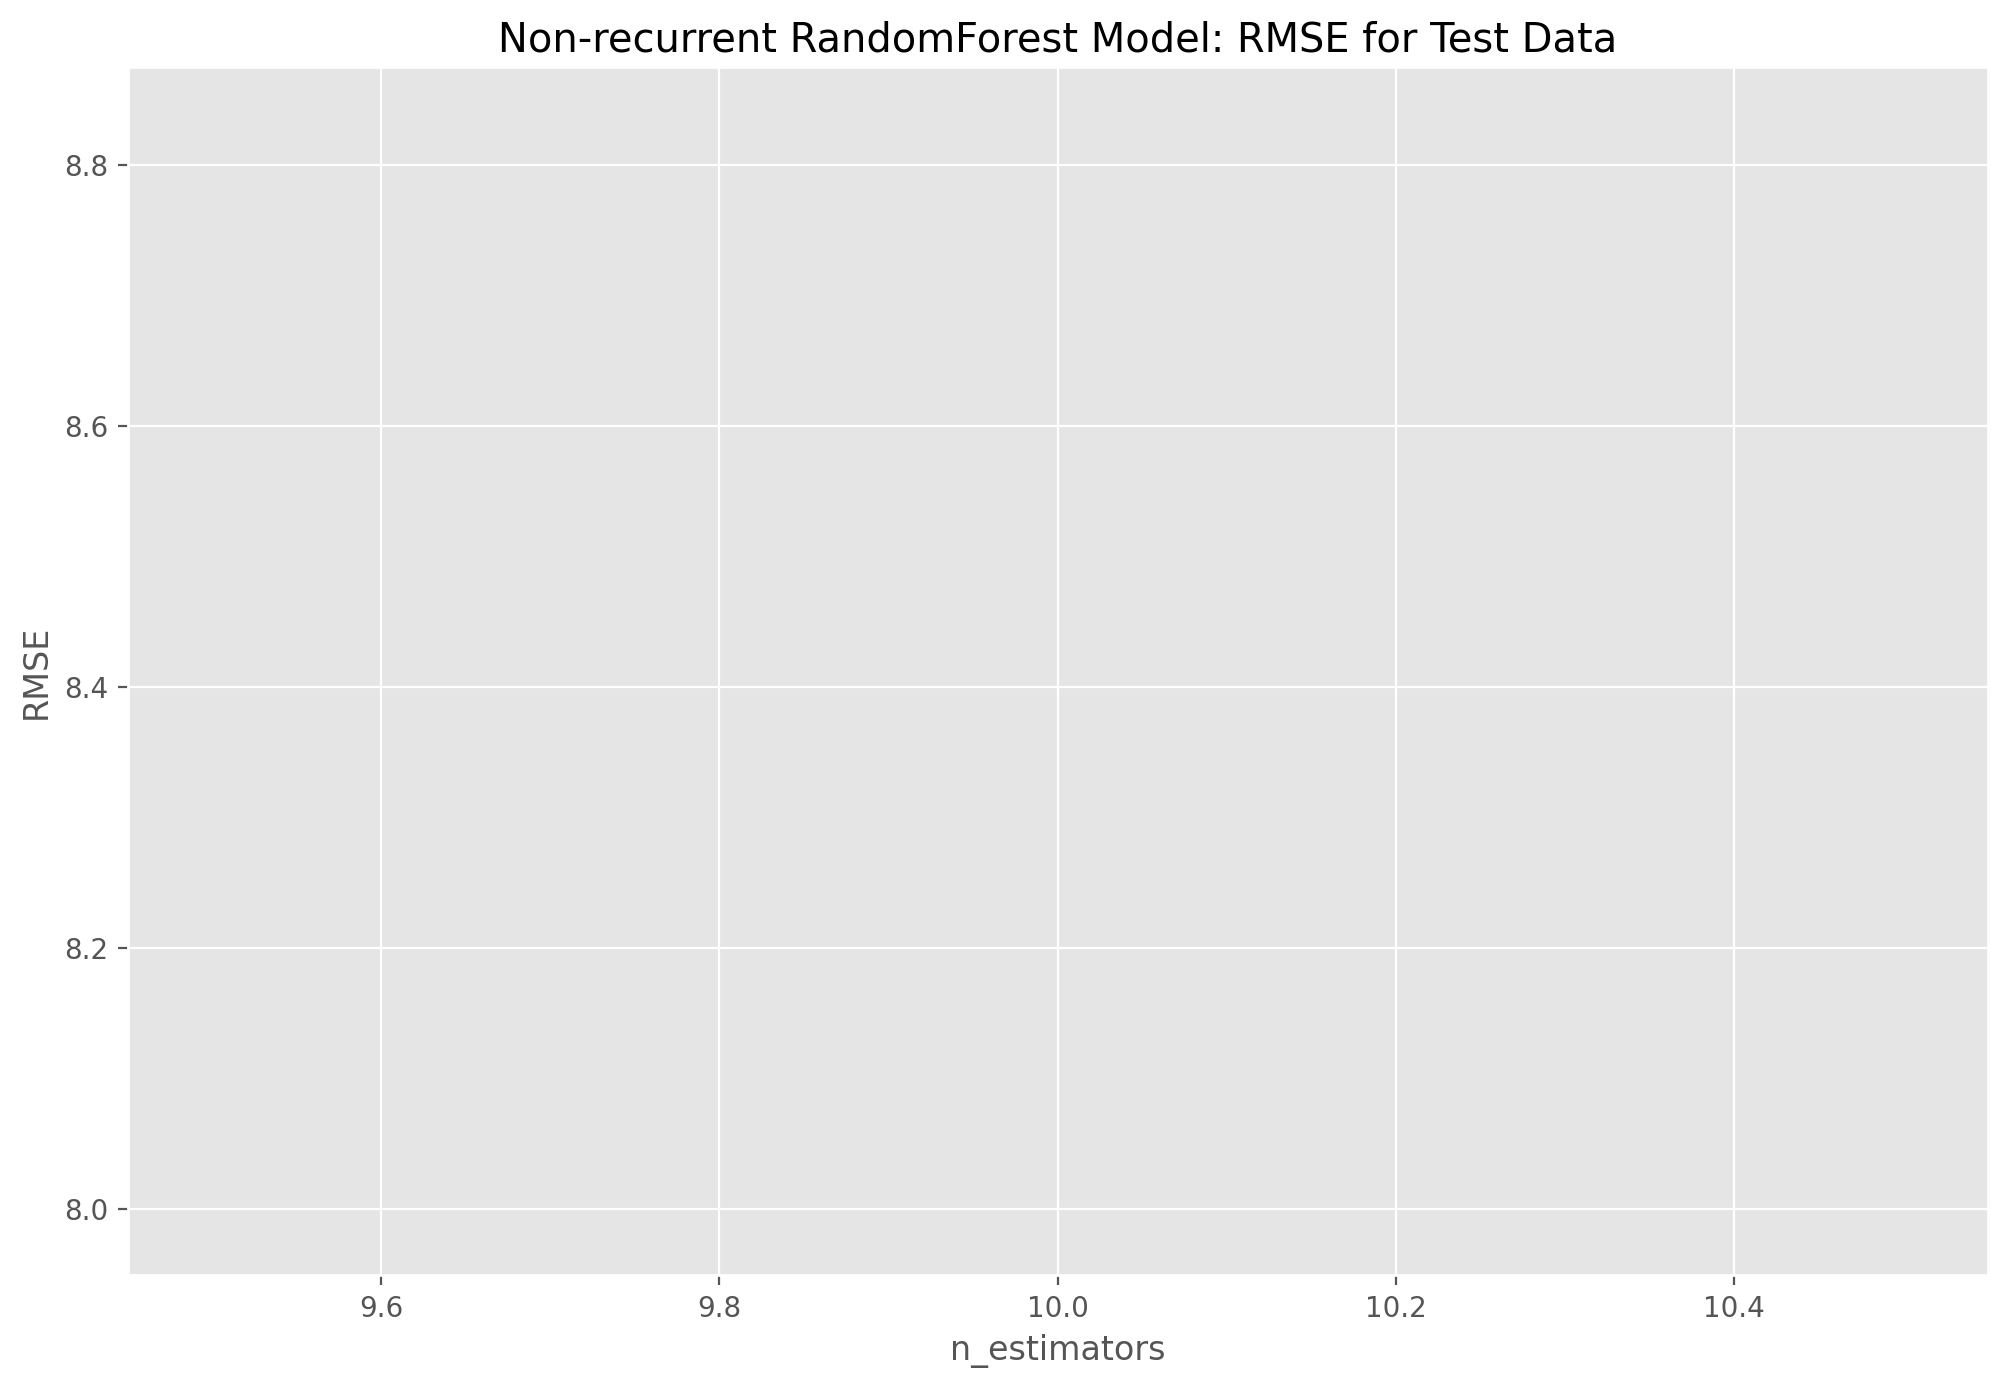

In [24]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

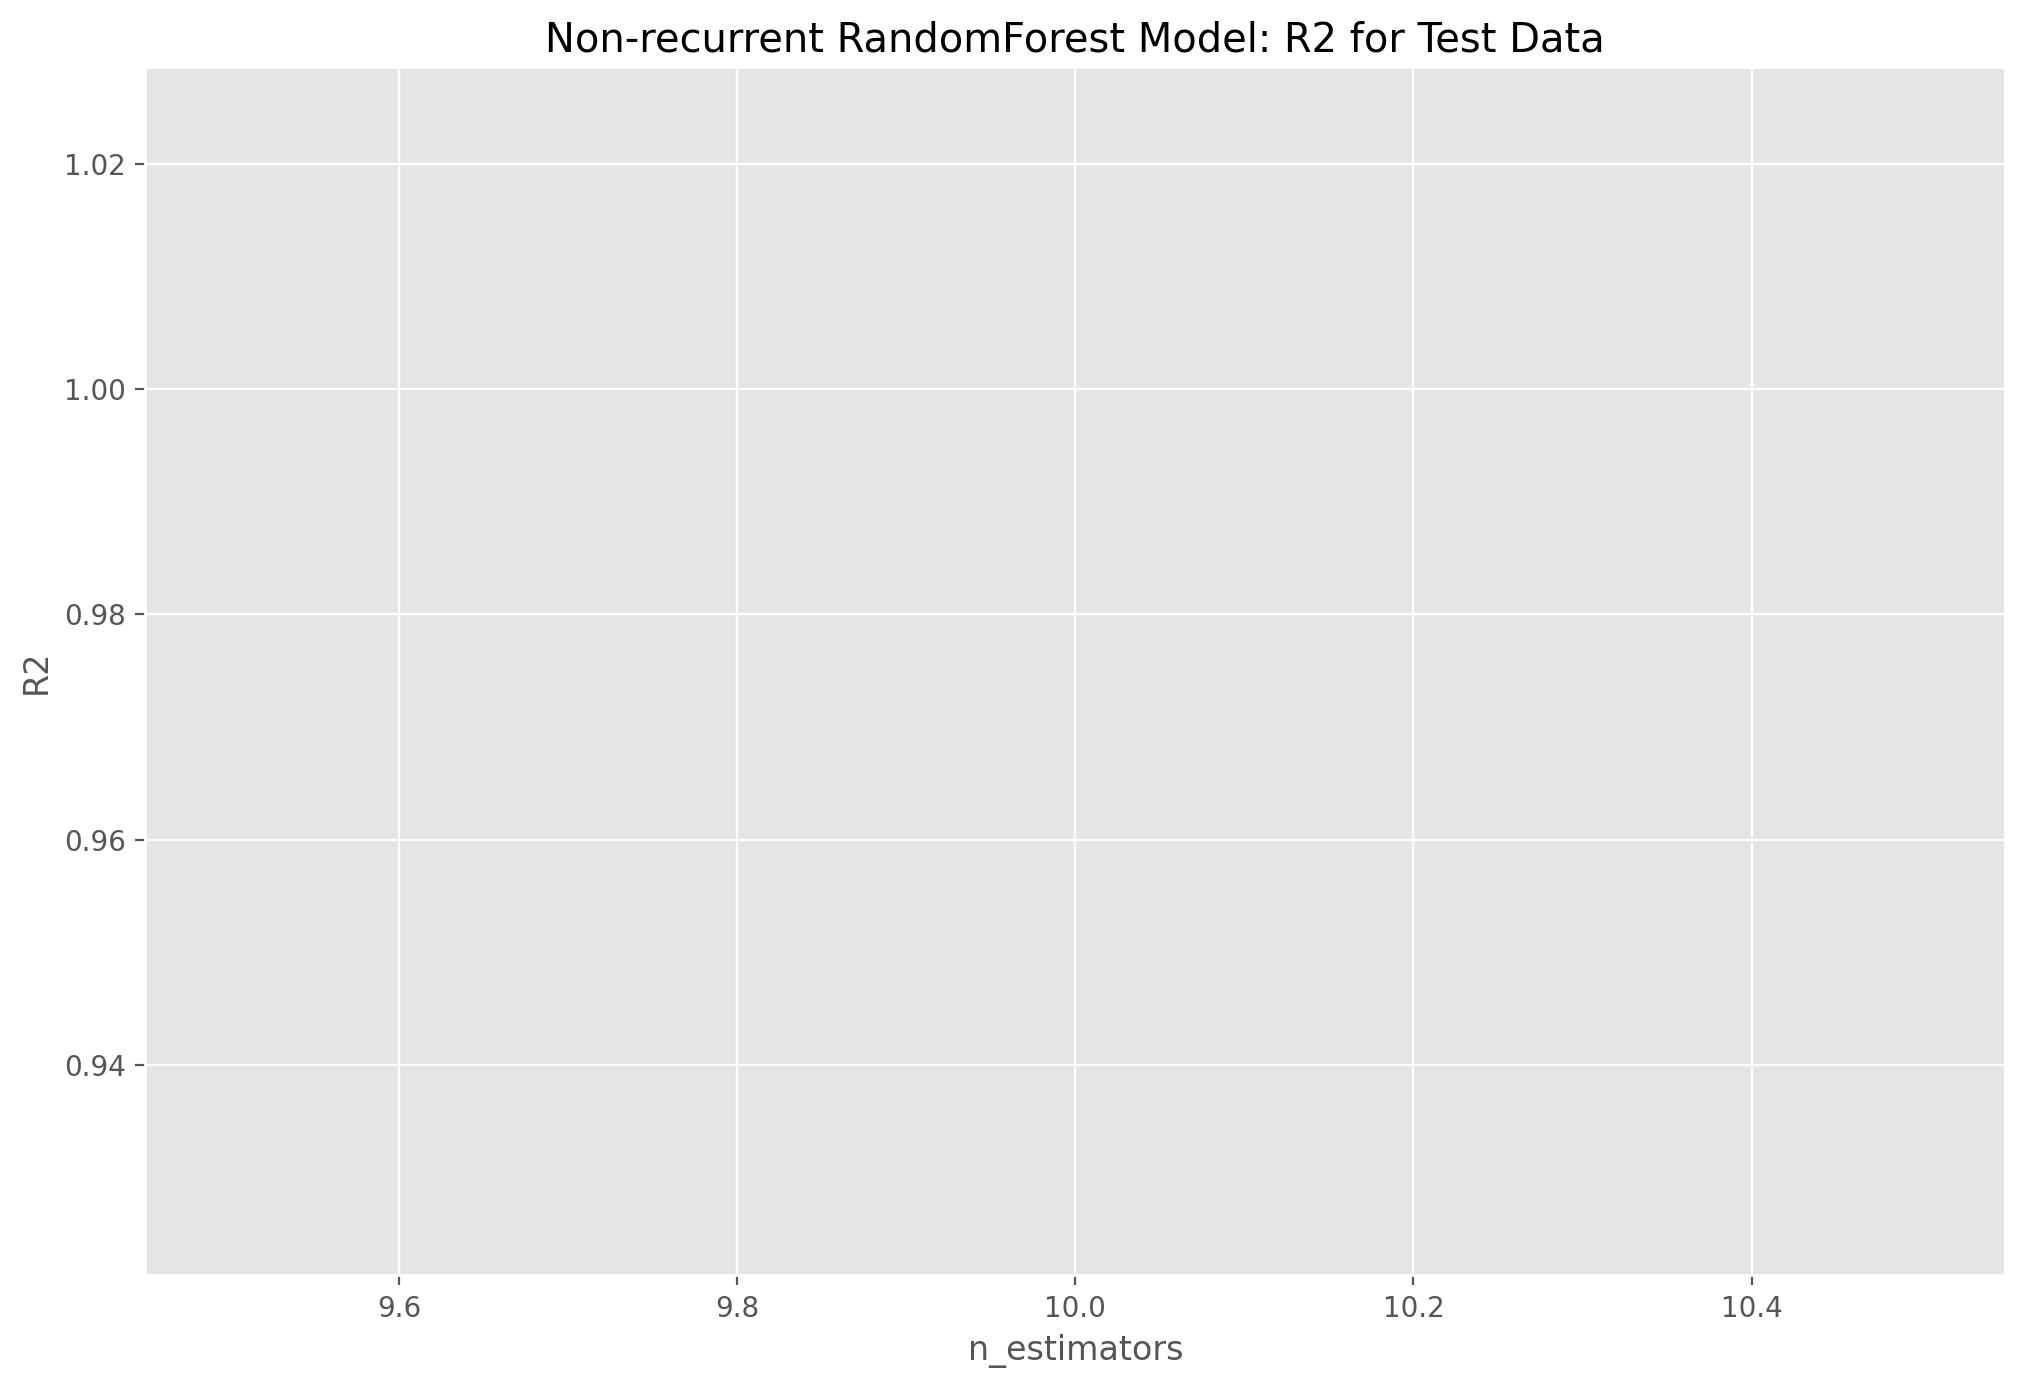

In [25]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")

In [26]:
model_type = 'RandomForest'
is_recurrent = False
target = 'h'
n_estimators = 10
n_shuffle_iterations = 1
per_case = False
x = 0

rmse_history, r2_history = get_shuffle_results(model_type, scenario_index, n_estimators, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x, calc_T_from_h=True)

Estimators: 10 Shuffle: 0 RMSE: 8.16192993114114 R2: 0.9778114136395335
RMSE_T: 7.1823534425482665 R2_T: 0.923724220382037
# of Estimators: 10, RMSE = 8.16193, r2 = 0.97781
RMSE_T: 7.1823534425482665 R2_T: 0.923724220382037


In [ ]:
model_type = 'XGBoost'
is_recurrent = False
target = 'h'
n_estimators = 300
n_shuffle_iterations = 20
per_case = False
x = 0
t = 40000

rmse_history, r2_history = get_shuffle_results(model_type, scenario_index, n_estimators, n_shuffle_iterations, is_recurrent, verbose=1, target=target, per_case=per_case, x=x, calc_T_from_h=True, short=True, t=t)

Estimators: 300 Shuffle: 0 RMSE: 3.8820524823339433 R2: 0.9948691348086184
RMSE_T: 2.1524048552194652 R2_T: 0.9961262154943549
Estimators: 300 Shuffle: 1 RMSE: 6.150004650854713 R2: 0.9848172935425021
RMSE_T: 3.0715955674084023 R2_T: 0.9943628658251007
Estimators: 300 Shuffle: 2 RMSE: 4.875305256953546 R2: 0.9893452857729891
RMSE_T: 3.4402484081591456 R2_T: 0.9931596588457738
Estimators: 300 Shuffle: 3 RMSE: 5.904778569469188 R2: 0.9848340265574996
RMSE_T: 3.5730667230395814 R2_T: 0.9763080894288426
Estimators: 300 Shuffle: 4 RMSE: 6.1403167214151155 R2: 0.9846664409579006
RMSE_T: 3.6739342326595343 R2_T: 0.9783141143120698
Estimators: 300 Shuffle: 5 RMSE: 5.634726486012646 R2: 0.9867058199218004
RMSE_T: 3.71529264870243 R2_T: 0.9782049674054228
